In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.stats import norm
from scipy.signal import find_peaks

In [2]:
# Directory containing the CSV files
folder_path = 'Back_EMF_Data'

# Dictionary to store DataFrames
dataframes = {}

# Loop through all files in the directory
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        # Read the CSV file and skip the header row
        file_path = os.path.join(folder_path, filename)
        df_name = os.path.splitext(filename)[0]
        df = pd.read_csv(file_path, skiprows=1, header=None)
        times = df[0]
        times = [time_point+abs(times[0]) for time_point in times]
        voltages = df[1]
        # Store the lists in the dictionary
        dataframes[df_name] = {'times': list(times), 'voltages': list(voltages)}

for experiment in dataframes:
    print(f"{experiment} has {len(dataframes[experiment]['times'])} data points")


M1_Blue has 131056 data points
M1_Red has 131056 data points
M1_Yellow has 131056 data points
M2_Blue has 131056 data points
M2_Red has 131056 data points
M2_Yellow has 131056 data points


In [3]:
def nice_plot_please(x, y, title, x_label, y_label):
    plt.figure(figsize=(5, 3))
    plt.plot(x, y,label="Voltage")
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show(block=False)

def nice_plot_please_two(x1, y1, x2, y2, title, x_label, y_label,data_name1,data_name2):
    plt.figure(figsize=(5, 3))
    plt.plot(x1, y1,label=data_name1)
    plt.plot(x2, y2,label=data_name2)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show(block=False)

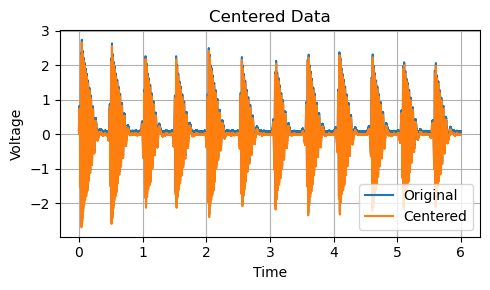

In [4]:
#dictionary of experiments, indexes as [value][0], 0 is time, 1 is voltage
example='M1_Blue'

#centering data about 0
centered_data = {}
for experiment in dataframes:
    mean = np.mean(dataframes[experiment]['voltages'])
    dataframes[df_name] = {'times': list(times), 'voltages': list(voltages)}
    centered_data[experiment]= {'times': dataframes[experiment]['times'], 'voltages' : [v - mean for v in dataframes[experiment]['voltages']]}

#dictionary of experiments, indexes as [value][0], 0 is time, 1 is voltage
nice_plot_please_two(dataframes[example]['times'],dataframes[example]['voltages'],centered_data[example]['times'],centered_data[example]['voltages'],"Centered Data","Time","Voltage","Original","Centered")


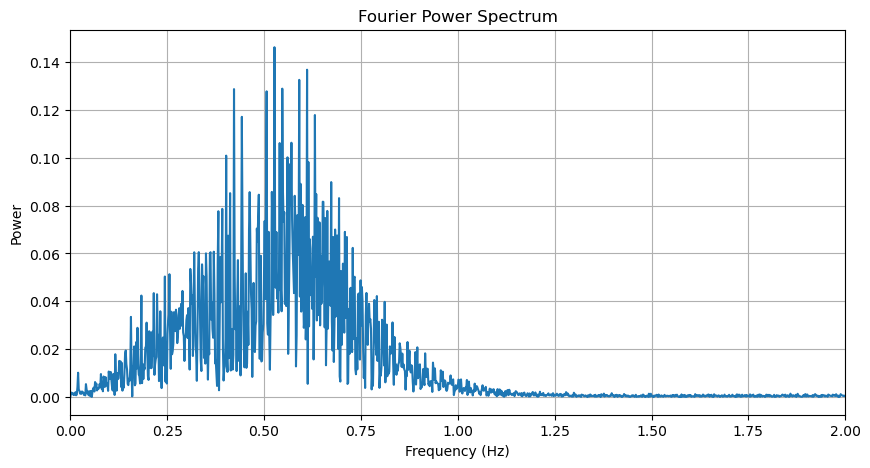

In [5]:
# Extract times and voltages from the example
times = np.array(centered_data[example]['times'])
voltages = np.array(centered_data[example]['voltages'])

# Compute the Fourier Transform of the voltages
N = len(voltages)
T = (times[99] - times[0]/100)  # Sample spacing
time_step = T

yf = fft(voltages)
xf = fftfreq(N, T)[:N//2]

# Compute the power spectrum
power = 2.0/N * np.abs(yf[:N//2])

# Plot the power spectrum
plt.figure(figsize=(10, 5))
plt.plot(xf, power)
plt.xlim(0, 2)
plt.title('Fourier Power Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.grid(True)
plt.show()


In [21]:
def back_emf_finder(experiment,data=centered_data,window_start=0,window_size=0,voltage_threshold=1,plot=False,):
    test_data= data[experiment]
    if window_size==0:
        window_size = len(test_data['times'])
    voltage_threshold=1

    # Adjust the distance and prominence parameters to widen the tolerance for peak detection
    peaks_positive, _ = find_peaks(test_data['voltages'][window_start:window_start+window_size], height=voltage_threshold, prominence=0.1, distance=100)
    peaks_negative, _ = find_peaks(-np.array(test_data['voltages'][window_start:window_start+window_size]), height=voltage_threshold, prominence=0.1, distance=100)
    peaks = np.concatenate((peaks_positive, peaks_negative))
    peaks=np.sort(peaks)
    peaks = peaks+window_start

    # Calculate the distance between consecutive peaks in time and voltage and calculate constant
    peak_distances = []
    peak_pairs = []
    back_emf = []
    for i in range(0, len(peaks) - 1, 2):
        time_distance = test_data['times'][peaks[i+1]] - test_data['times'][peaks[i]]
        if time_distance>0.02:
            continue
        peak_pairs.append((peaks[i], peaks[i+1]))
        voltage_distance = test_data['voltages'][peaks[i+1]] - test_data['voltages'][peaks[i]]
        peak_distances.append((time_distance, voltage_distance))
        back_emf.append((1/np.sqrt(3))*abs(voltage_distance*time_distance))

    # # Print the distances
    # for i, (time_dist, volt_dist) in enumerate(peak_distances):
    #     print(f"Peak pair {i+1}: Time distance = {time_dist}, Voltage distance = {volt_dist}")
    #     print(f"Constant = {((1/np.sqrt(3))*abs(volt_dist*time_dist))}")

    if plot == True:
        plt.figure(figsize=(5, 3))
        plt.plot(test_data['times'][window_start:window_start+window_size], test_data['voltages'][window_start:window_start+window_size], label="Voltage")
        for i, (pair) in enumerate(peak_pairs):
            plt.plot([test_data['times'][pair[0]], test_data['times'][pair[1]]], [test_data['voltages'][pair[0]], test_data['voltages'][pair[1]]], "x")
        plt.title("Voltage Peaks")
        plt.xlabel("Time")
        plt.ylabel("Voltage")
        plt.grid(True)
        plt.tight_layout()
        plt.show(block=False)

    return back_emf


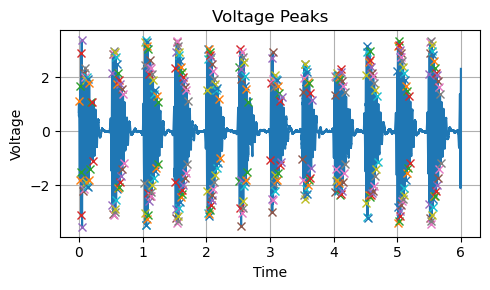

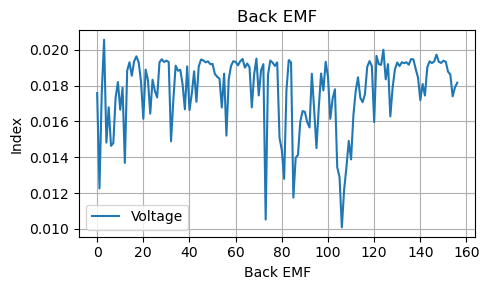

In [43]:
test = 'M1_Yellow'
back_emf = back_emf_finder(test,centered_data,True)
nice_plot_please(range(len(back_emf)),back_emf,"Back EMF","Back EMF","Index")

In [44]:
all_back_emf = []
experiment_start_points=[0]
for experiment in centered_data:
    i=0
    if experiment == 'M1_Yellow':
        continue
    print(f"Experiment: {experiment}")
    back_emf = back_emf_finder(experiment, plot=False)
    all_back_emf.extend(back_emf)
    experiment_start_points.append(all_back_emf[i]+len(all_back_emf))
    i+=1

Experiment: M1_Blue
Experiment: M1_Red
Experiment: M2_Blue
Experiment: M2_Red
Experiment: M2_Yellow


Mean: 0.018536908163345873, Standard Deviation: 0.0009123534474339204


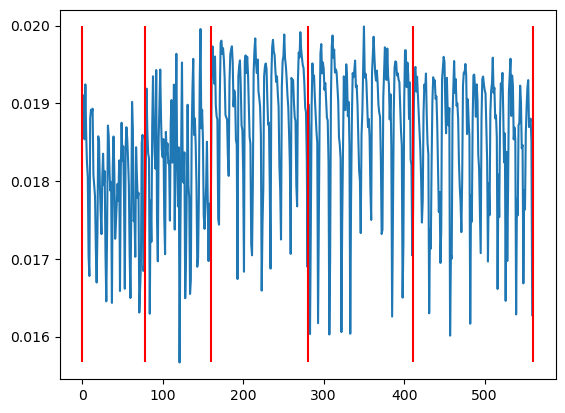

In [46]:
plt.plot(all_back_emf)
plt.vlines(experiment_start_points,min(all_back_emf),max(all_back_emf),color='r')
print(f"Mean: {np.mean(all_back_emf)}, Standard Deviation: {np.std(all_back_emf)}")